In [18]:
## Code courtsey: Manav Sehgal (https://www.kaggle.com/startupsci)
## Link to Original Code: https://www.kaggle.com/startupsci/titanic-data-science-solutions

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

def titanic(train, test):
    train_df = pd.read_csv(train)
    test_df = pd.read_csv(test)
    combine = [train_df, test_df]

    train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
    test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
    combine = [train_df, test_df]

    for dataset in combine:
        dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

    pd.crosstab(train_df['Title'], train_df['Sex'])

    for dataset in combine:
        dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

        dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    for dataset in combine:
        dataset['Title'] = dataset['Title'].map(title_mapping)
        dataset['Title'] = dataset['Title'].fillna(0)

    train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
    test_df = test_df.drop(['Name'], axis=1)
    combine = [train_df, test_df]

    for dataset in combine:
        dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

    guess_ages = np.zeros((2,3))
    guess_ages

    for dataset in combine:
        for i in range(0, 2):
            for j in range(0, 3):
                guess_df = dataset[(dataset['Sex'] == i) & \
                                      (dataset['Pclass'] == j+1)]['Age'].dropna()

                # age_mean = guess_df.mean()
                # age_std = guess_df.std()
                # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

                age_guess = guess_df.median()

                # Convert random age float to nearest .5 age
                guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

        for i in range(0, 2):
            for j in range(0, 3):
                dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                        'Age'] = guess_ages[i,j]

        dataset['Age'] = dataset['Age'].astype(int)

    for dataset in combine:
        dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1



    for dataset in combine:
        dataset['IsAlone'] = 0
        dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

    combine = [train_df, test_df]

    freq_port = train_df.Embarked.dropna().mode()[0]

    for dataset in combine:
        dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

    test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
    
    train_df = pd.get_dummies(train_df)
    test_df  = pd.get_dummies(test_df)

    test_df.head(10)
    return (train_df, test_df)

In [22]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
import time

def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed




In [4]:
train = 'train.csv'
test = 'test.csv'
titanic_train,titanic_test = titanic(train, test)

In [5]:
Y = titanic_train['Survived']

In [6]:
X = titanic_train.iloc[:,1:]

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [24]:
@timeit
def grid_output(parameters,X,Y,clf):
    num_test = 0.20
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = num_test,random_state = 23)
    acc_scorer = make_scorer(accuracy_score)
    grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
    grid_obj = grid_obj.fit(X_train, Y_train)    
    return grid_obj.cv_results_

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

@timeit
def plot_data(X,Ytest,Ytrain):
    plt.plot(X,Ytest,'r-',X,Ytrain)
    plt.xlabel('Estimator')
    plt.ylabel('Mean Scores')
    plt.show()
    return plt

In [26]:
# parameters = {'n_estimators': [4, 6, 9], 
#               'max_features': ['log2', 'sqrt','auto'], 
#               'criterion': ['entropy', 'gini'],
#               'max_depth': [2, 3, 5, 10], 
#               'min_samples_split': [2, 3, 5],
#               'min_samples_leaf': [1,5,8]
#              }

parameters1 = {'n_estimators': [2,4,6,8,16,32]}
parameters2 = {'max_depth': [2, 3, 5, 10]}
parameters3 = {'min_samples_split': [2, 3, 5]}

'grid_output'  1730.96 ms


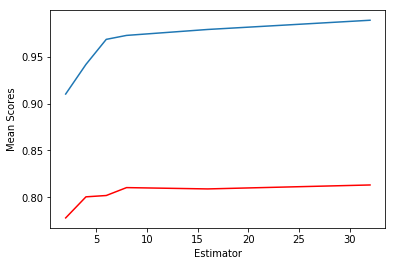

'plot_data'  337.79 ms


<module 'matplotlib.pyplot' from '/home/pramod/anaconda2/envs/greyatom/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [27]:
clf1 = RandomForestClassifier(oob_score=True)
t1 = grid_output(parameters1,X,Y,clf1)
plot_data(parameters1['n_estimators'],t1['mean_test_score'],t1['mean_train_score'])

'grid_output'  1114.79 ms


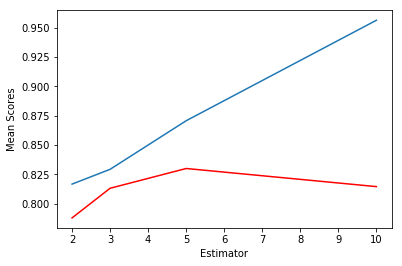

'plot_data'  338.09 ms


<module 'matplotlib.pyplot' from '/home/pramod/anaconda2/envs/greyatom/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [28]:
clf2 = RandomForestClassifier(oob_score=True)
t2 = grid_output(parameters2,X,Y,clf2)
plot_data(parameters2['max_depth'],t2['mean_test_score'],t2['mean_train_score'])

'grid_output'  959.14 ms


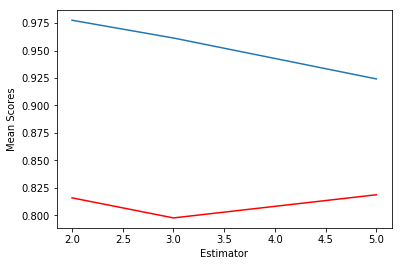

'plot_data'  323.02 ms


<module 'matplotlib.pyplot' from '/home/pramod/anaconda2/envs/greyatom/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [29]:
clf3 = RandomForestClassifier(oob_score=True)
t3 = grid_output(parameters3,X,Y,clf3)
plot_data(parameters3['min_samples_split'],t3['mean_test_score'],t3['mean_train_score'])

In [30]:
parameters2['max_depth']

[2, 3, 5, 10]